# NLP Task - Classify real news from fake news
### Importing libraries and importing Datasets

In [3]:
import pandas as pd
import numpy as np
import os, time, gc, re

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors

import torch
from torch import nn, Tensor, device
from torch.optim import Optimizer
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from keras.preprocessing.text import Tokenizer 
import torch.nn.functional as F
from torch.nn.utils.rnn import  pack_padded_sequence , pad_sequence

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report
from datetime import datetime
import random
import json
import requests
import math
import pickle
import sys
import time

from tqdm.autonotebook import trange
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
from IPython.display import clear_output
clear_output()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

    
from IPython.display import display
from IPython.core.display import HTML

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
real = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/database/News/True.csv')
fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/database/News/Fake.csv')
fake['Fake'] = True
real['Fake'] = False
data = pd.concat([real , fake])
data['news'] = data['title'] + ' - ' + data['text'] 
data['length'] = data.news.apply(lambda x: len(x.split(' ')))
data = data.sample(frac = 1.0)

In [5]:
display(HTML('<h3>Sample Data From Fake Dataset</h3>'))
fake.sample(5)

,title,text,subject,date,Fake
15847,"JIHAD FOR DUMMIES: How US Army Enlistee, Moham...",Note to little Johnny you might want to consid...,politics,"Apr 10, 2015",True
9310,JUST IN: Flynn to Plead Guilty to Lying to the...,The broader story in this entire Russia witch ...,politics,"Dec 1, 2017",True
10849,“GOOD-BYE SWEDEN”: How Muslim Violence…Porous ...,This blogger s piece is a glimpse into the fut...,politics,"May 18, 2017",True
974,WATCH: Kellyanne Conway Runs From Reporter As...,White House counselor Kellyanne Conway likes t...,News,"June 29, 2017",True
23108,Aleppo Truth: Incredible Press Conference at t...,SEE MORE ALEPPO UPDATES & EXCLUSIVES HEREThis ...,Middle-east,"December 12, 2016",True


In [6]:
display(HTML('<h3>Sample Data From Real Dataset</h3>'))
real.sample(5)

,title,text,subject,date,Fake
10231,"Trump vows strong U.S. ties with Israel, draws...",WASHINGTON (Reuters) - Republican presidential...,politicsNews,"March 21, 2016",False
8710,Justice Department changes social media policy...,WASHINGTON (Reuters) - The U.S. Justice Depart...,politicsNews,"July 19, 2016",False
2228,Reports suggest North Korea treating foreign d...,GENEVA (Reuters) - Foreign detainees in North ...,politicsNews,"August 11, 2017",False
20798,Merkel tells voters: 'don't experiment' with t...,BERLIN (Reuters) - Chancellor Angela Merkel wa...,worldnews,"September 7, 2017",False
17002,Pakistani anti-corruption court indicts ousted...,ISLAMABAD (Reuters) - A Pakistani anti-corrupt...,worldnews,"October 19, 2017",False


In [7]:
display(HTML(f'<b>Fake Dataset Shape</b> : {fake.shape[0]} Rows * {fake.shape[1]} Columns'))
display(HTML(f'<b>Real Dataset Shape</b> : {real.shape[0]} Rows * {real.shape[1]} Columns'))

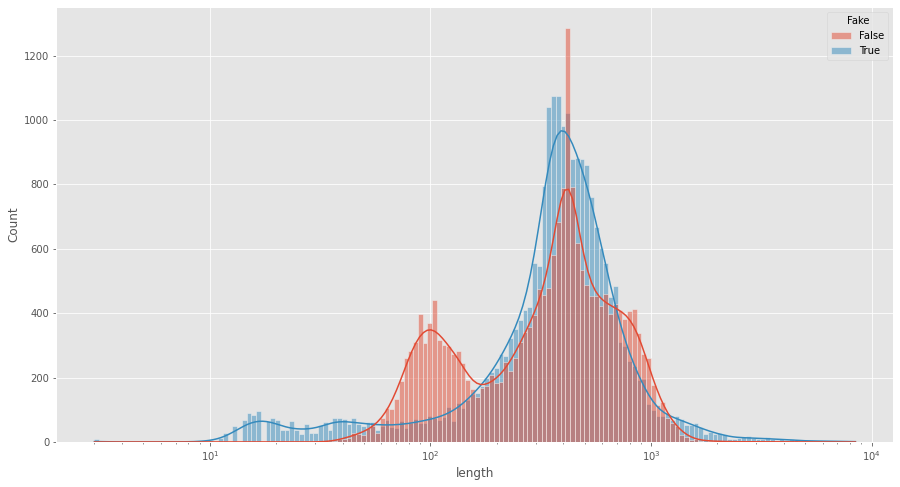

In [8]:
display(HTML(f"Count plot of Length of Text in Dataset"))
fig, axs = plt.subplots(figsize=(15, 8))
sns.histplot(data, x = 'length', hue = 'Fake',ax = axs, kde = True, log_scale=True)
# sns.histplot(fake.text.apply(lambda x : len(x.split(' '))) , color = 'red', ax = axs)
# sns.histplot(real.text.apply(lambda x : len(x.split(' '))) , color = 'blue' , ax = axs)


In [9]:
lemma = nltk.WordNetLemmatizer()
def normalize(text):
    text = re.sub(r'U.S.|US|U.S.A','US',text)
    text = re.sub(r'(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^\x00-\x7F]+)|([0-9])|(\w+:\/\/\S+)|([^\w\s])|(\s+)', ' ', text)
    text = text.strip().lower()
    text = re.sub(r'\s+', ' ', text)

    text = nltk.word_tokenize(text) # Tokenizing
    text = [lemma.lemmatize(word) for word in text] # Lemmatizing
    text = " ".join(text)
    return text

data['news'] = data['news'].apply(normalize)


In [10]:
data.sample(10)

,title,text,subject,date,Fake,news,length
4195,SICK: Trump Told 14-Year-Old Girls He Would B...,Another bit of news from the past has come bac...,News,"October 14, 2016",True,sick trump told year old girl he would be dati...,436
17609,"Trump lays out new Iran strategy Friday, compl...",WASHINGTON (Reuters) - President Donald Trump ...,worldnews,"October 12, 2017",False,trump lay out new iran strategy friday complic...,665
3754,"Trump Faked Out Fans, Used Machine To Autogra...",Donald Trump supporters thought that when they...,News,"November 19, 2016",True,trump faked out fan used machine to autograph ...,334
13108,RED ALERT: CLINTON DESTROYED EVIDENCE IN TWO W...,,politics,"Sep 2, 2016",True,red alert clinton destroyed evidence in two wa...,14
11678,Turkish PM calls Rohingya killings in Myanmar ...,"COX S BAZAR, Bangladesh (Reuters) - Turkey s p...",worldnews,"December 20, 2017",False,turkish pm call rohingya killing in myanmar ge...,477
14468,OBAMA SPEAKS ON SUPREME COURT NOMINEE And Take...,I feel like I ve been drugged by Obama s rhet...,politics,"Feb 16, 2016",True,obama speaks on supreme court nominee and take...,218
4675,‘Pharma Bro’ Just Yelled This At Hillary To R...,You may have heard that Hillary Clinton had a ...,News,"September 11, 2016",True,pharma bro just yelled this at hillary to remi...,409
15418,U.S. calls for U.N. action against Iran over Y...,UNITED NATIONS (Reuters) - The United States a...,worldnews,"November 7, 2017",False,u call for u n action against iran over yemen ...,503
8838,"Former Obama Adviser BLASTS Trump, Calls Him ...",Donald Trump has helped America s racists feel...,News,"January 10, 2016",True,former obama adviser blast trump call him out ...,358
11024,Obama to seek $755 million for cancer 'moonsho...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"February 1, 2016",False,obama to seek million for cancer moonshot whit...,331



#Possible ways to solve this Problem
*   Training Any DNN Model from Scratch and Training that over Complete Dataset.
*   Machine Learning Approch : Tokenizing the Dataset and using Word2Vec followed by Any Machine Learning Model like Random Forest or KNN.
*   Using Any pretrained Sentence Embedding Like BERT or GPT-2 followed by ANN to calculate Fake News in Dataset


## Advantages of using Pretrained Sentence Embedding
* Faster Compution due to Simpler Artitecture
* Can Take Advantage of Pretrained BERT Network
* Sentence sizes are Long and required 16+ Gb of RAM if not truncated while implementing LSTM Network
* Vocab size is 1,00,000+ Making Embedding Matrix Very large and Computationaly Expensive

In [59]:
class Model(nn.Module):
    def __init__(self, ntoken = 768, nout = 1):
        super(Model, self).__init__()
        self.model_type = 'ANN Model'
        self.encoder = nn.Linear(ntoken , ntoken*2)
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(ntoken*2)
        self.decoder = nn.Linear(ntoken*2, nout)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(.25)

    def forward(self, x):
        x = self.encoder(x)
        x = self.norm(self.relu(x))
        x = self.dropout(x)
        x = self.decoder(x)
        return self.sigmoid(x.squeeze())

In [55]:
class TrainerDataset:
    def __init__(self, dataset ,target):
        self.dataset = dataset
        self.target = target

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        target = self.target[item]
        item = self.dataset[item]
        # print(item)
        return torch.tensor(item) , torch.tensor(target, dtype=torch.float32)

def create_dataloader():
    train_data = TrainerDataset(embeddings[:40000] , data.Fake.values[:40000])
    train_data = DataLoader(train_data , batch_size = 64 , shuffle = True , drop_last = True)

    valid_data = TrainerDataset(embeddings[40000:], data.Fake.values[40000:])
    valid_data = DataLoader(valid_data , batch_size = 64 , shuffle = True , drop_last = True)

    return train_data , valid_data

In [ ]:
embeddings = model.encode(data.news.values , normalize_embeddings= True ,batch_size= 128, device= 'cuda', show_progress_bar= True )

In [23]:
train_loader , valid_loader = create_dataloader()

In [71]:
class Pytorch_Trainer():
    """
    Custom Pytorch Trainer Model Which makes easy to Train Pytorch Model
    BY: KAUSTUBH PATHAK
    """
    def __init__(self):
        super().__init__()
        self._BT_Avg_Loss_Train = []
        self._BT_Avg_Loss_Valid = []
        self._Loss_df = []
        self.max_grad_norm = 1
        self.__Use_CLR = False
        self.model_save_path = '/content/drive/MyDrive/LambdaTest/models_2'
        os.makedirs(self.model_save_path, exist_ok=True)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # To Save Model after Training (Trainer dont have Automatic Saving to Save Best Model while Training { To Implement})
    def _Save_Model(self , model , optimizer ,  path):
        checkpoint = {
            'Training Loss': self._BT_Avg_Loss_Train,
            'Validation Loss': self._BT_Avg_Loss_Valid,
            'Loss df': self._Loss_df,
            'Optimizer': optimizer.state_dict(),
            'State_Dict': model.state_dict()
                     }
        torch.save(checkpoint , path)
        print('Model Saved Successfully....')

    # Load the Saved Model and Optimizer
    def _Load_Model(self, model, optimizer ,path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['State_Dict'])
        self._BT_Avg_Loss_Train = checkpoint['Training Loss']
        self._BT_Avg_Loss_Valid = checkpoint['Validation Loss']
        self._Loss_df = checkpoint['Loss df']
        optimizer.load_state_dict(checkpoint['Optimizer'])
        print('Loading Completed....')
        return model, optimizer

    # Switch Between Training and Evaluation modes.
    def _Train_Eval(self , model , mode):
        if mode.lower() == 'train':
            model.train()
            torch.set_grad_enabled(True)
        elif mode.lower() == 'eval':
            model.eval()
            torch.set_grad_enabled(False)
        else:
            raise Exception("Unknown Type....!! Set to 'Train' or 'Eval'")

    # Predict Function (Correctly {Not for Large Datasets.})
    def _Predict(self , model, x):
        model._Train_Eval(mode = 'Eval')
        x = torch.tensor(x).to(device)
        return  model(x).detach()

    # Run/Train the Model with Automatic Mixed Precision
    def fit(self , model , optimizer , loss , dataloader , validloader ,scheduler = None,ex_flag = 0, epochs = 'Default' , use_grad = False):
        print('Abbreviations : \n\tV.S. -> Validation Size \tV.L. -> Validation Loss \tT.S. -> Training Size \tT.L. -> Training Loss \tT.T. -> Training Time\nResults : ')
        loss = loss.to(self.device)
        model = model.to(self.device)
        if epochs == 'Default':
            epochs = 5
        if use_grad:
            scaler = GradScaler()

        for j in range(epochs):
            time_now = time.time()
            self._Train_Eval(model, mode = 'Train')
            Train_Total_Loss = 0 #For Epoch Loss
            for x_train , target in dataloader:
                x_train , target = x_train.to(device) , target.to(device)

                optimizer.zero_grad()
                if use_grad:
                    with autocast():
                        embed_x = model.__call__(x_train )
                        loss_value = loss(embed_x, target)
                    scale_before_step = scaler.get_scale()
                    scaler.scale(loss_value).backward()
                    scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.max_grad_norm)
                    scaler.step(self.optimizer)
                    scaler.update()
                    skip_scheduler = scaler.get_scale() != scale_before_step
                else:
                    embed_x = model.__call__(x_train )
                    loss_value =  loss(embed_x, target)

                    loss_value.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), self.max_grad_norm)
                    optimizer.step()
                if scheduler != None:
                    scheduler.step() # Stepping If using Cyclic Learning Rate ()
                
                self._BT_Avg_Loss_Train.append([j,ex_flag,loss_value.item()]) # Otherwise Simple Append

                Train_Total_Loss += loss_value.item() #For Epoch Loss
                ex_flag += 1 #Flag

            #### For Evaluation ....
            self._Train_Eval(model , mode = 'Eval') # Switching to Evaluation Mode
            ex_flag = 0 #Flag
            Valid_Total_Loss = 0 # For Calculating Validation Loss

            for x_train  ,  target in validloader:
                x_train , target = x_train.to(device) , target.to(device)

                if use_grad:
                    with autocast():
                        embed_x = model.__call__(x_train )
                        loss_value = loss(embed_x, target)
                else:
                    embed_x  = model.__call__(x_train ) # Calling to get Prediction
                    loss_value = loss(embed_x, target) # Calculating the Loss
                self._BT_Avg_Loss_Valid.append([j,ex_flag , loss_value.item()]) # Otherwise Simple Append
                Valid_Total_Loss += loss_value.item() #Epoch Validation Loss
                ex_flag += 1 #Flag
            # self._Save_Model(model , optimizer , f'{self.model_save_path}/epochs{j+1}_ex_flag_{ex_flag}.pt')
            print('Epoch : {} | V.S. : {} | V.L. : {:07.5f} | T.S. : {} | T.L : {:07.5f} | T.T. : {:05.3f} Sec ||'.\
                        format(\
                                j+1 , \
                                len(validloader),round(Valid_Total_Loss / len(validloader) , 5) ,
                                len(dataloader) , round(Train_Total_Loss / len(dataloader) , 5) ,
                                round(time.time() - time_now,3)
                                )\
                        )

            self._Loss_df.append(
                            {
                            'Epoch':j ,
                            'Training Loss': Train_Total_Loss/len(dataloader) ,
                            'Validation Loss':  Valid_Total_Loss / len(validloader)
                            }
                        )


In [72]:
ann_model = Model()
trainer = Pytorch_Trainer()
loss = nn.BCELoss()

optimizer = torch.optim.Adam(ann_model.parameters(), lr=1.0*0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
trainer.fit(ann_model , optimizer, loss, train_loader , valid_loader)

Abbreviations : 
	V.S. -> Validation Size 	V.L. -> Validation Loss 	T.S. -> Training Size 	T.L. -> Training Loss 	T.T. -> Training Time
Results : 
Epoch : 1 | V.S. : 76 | V.L. : 0.10031 | T.S. : 625 | T.L : 0.12685 | T.T. : 2.837 Sec ||
Epoch : 2 | V.S. : 76 | V.L. : 0.10348 | T.S. : 625 | T.L : 0.08032 | T.T. : 2.797 Sec ||
Epoch : 3 | V.S. : 76 | V.L. : 0.07774 | T.S. : 625 | T.L : 0.05825 | T.T. : 2.816 Sec ||
Epoch : 4 | V.S. : 76 | V.L. : 0.07287 | T.S. : 625 | T.L : 0.04269 | T.T. : 2.809 Sec ||
Epoch : 5 | V.S. : 76 | V.L. : 0.07051 | T.S. : 625 | T.L : 0.03039 | T.T. : 2.797 Sec ||


              precision    recall  f1-score   support

   Real News       0.99      1.00      0.99     19105
   Fake News       1.00      0.99      0.99     20895

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



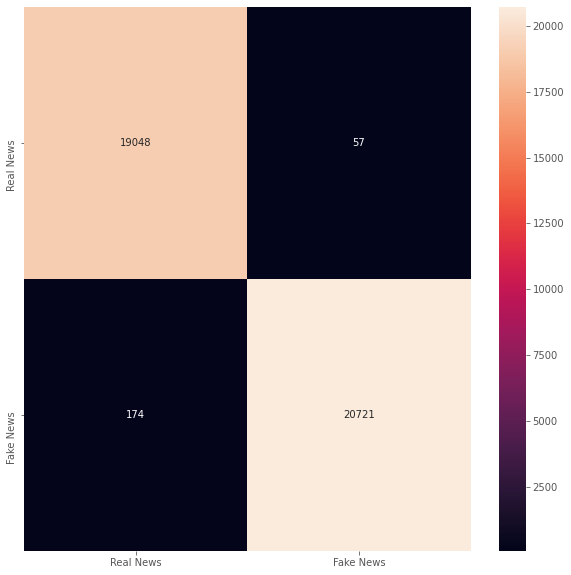

In [85]:
pred = []
target = []
ann_model.eval()
for embedss , targets in train_loader:
    preds = ann_model(embedss.to(device))
    pred.append(preds.detach().cpu().numpy())
    target.append(targets.cpu().numpy())
pred , target = np.hstack(pred) , np.hstack(target)
result = pred > .5
result = [int(i) for i in result]
accuracy_value = roc_auc_score(target,pred)
display(HTML(f"<b>Accuracy Over Training Dataset</b> - {round(accuracy_value*100 , 3)}% <br><br><b>Classification Report</b>"))
print(classification_report(target, result, target_names=['Real News', 'Fake News']))
display(HTML(f"<br><b>Confusion Matrix</b>"))
cm = confusion_matrix(target, result)
plt.figure(figsize = (10, 10))
sns.heatmap(pd.DataFrame(cm , index = ['Real News' , 'Fake News'] , columns = ['Real News', 'Fake News']), annot = True,fmt='g')

              precision    recall  f1-score   support

   Real News       0.97      0.98      0.98      2292
   Fake News       0.98      0.98      0.98      2572

    accuracy                           0.98      4864
   macro avg       0.98      0.98      0.98      4864
weighted avg       0.98      0.98      0.98      4864



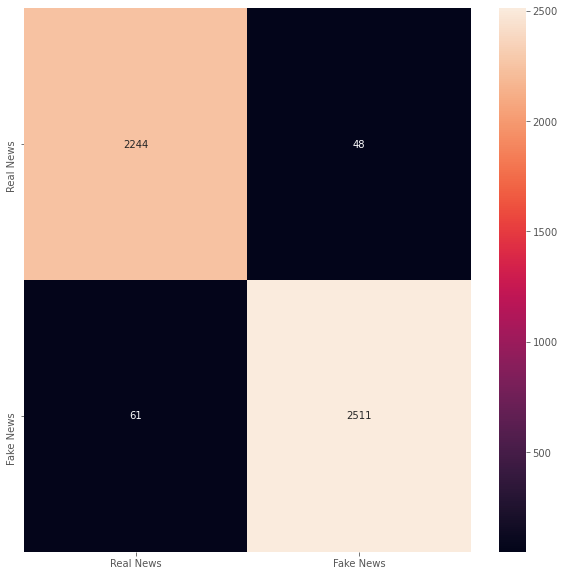

In [84]:
pred = []
target = []
ann_model.eval()
for embedss , targets in valid_loader:
    preds = ann_model(embedss.to(device))
    pred.append(preds.detach().cpu().numpy())
    target.append(targets.cpu().numpy())
pred , target = np.hstack(pred) , np.hstack(target)
result = pred > .5
result = [int(i) for i in result]
accuracy_value = roc_auc_score(target,pred)
display(HTML(f"<b>Accuracy Over Testing Dataset</b> - {round(accuracy_value*100 , 3)}% <br><br><b>Classification Report</b>"))
print(classification_report(target, result, target_names=['Real News', 'Fake News']))
display(HTML(f"<br><b>Confusion Matrix</b>"))
cm = confusion_matrix(target, result)
plt.figure(figsize = (10, 10))
sns.heatmap(pd.DataFrame(cm , index = ['Real News' , 'Fake News'] , columns = ['Real News', 'Fake News']), annot = True,fmt='g')